In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [4]:
@tool
def get_stock_price(symbol: str) -> float: #dummy function, normally it'd have to call Yahoo Finance or other tool
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price] #contains all important tools, might have more functions

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools)

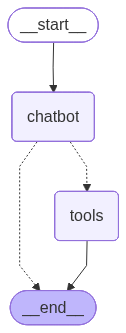

In [5]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools)) #ToolNode is  a prebuilt class of langgraph

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition) #tools condition is also prebuilt, it returns either tools or end

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [7]:
state

{'messages': [HumanMessage(content='What is the price of AAPL stock right now?', additional_kwargs={}, response_metadata={}, id='11427ecb-1645-478d-b1cc-94b5888d5d32'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "AAPL"}'}, '__gemini_function_call_thought_signatures__': {'b2c9ffa8-6122-453b-96b8-f670ca44efe1': 'CpwCAXLI2nx9Mp7tUvHEzwRNKpz4q1Q/QIhlHkLX4FBI8cjQqetroPOwFQ8+ZEQ+pqTBPoOKmeYw9pp48Umd8rBvrDTVXy+0wrvCADh9zaWq/MeJV197bT8TPprt4dGL9RXk48S6IZDaFE1FqPgdVWBNW+OYwNFe+h421/pDEp5lgdaStvXl8rdlal6EBEhJ+etDHBN12MievKQtx0SLUxBxBqU8DSX7TqgTlLKRbGO1TnHreI72rP3QKgIxAb8pw+wY1pa5rFqDqzqAUJJvMLaI8E/VWCNWuvSI3ZQTlt/vsNFbpobWTSUYY+4MYBG/J0dwdbKHP+deIvl8gmmiUiCiIa9eVvUbBB8XvQpPo2LfVw59uBBOBaBx24Tints='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bfbac-3157-7fa2-95f4-2898bea22da5-0', tool_calls=[{'name': 'get_stock_price', '

In [8]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [9]:
state

{'messages': [HumanMessage(content='Who invented theory of relativity? print person name only', additional_kwargs={}, response_metadata={}, id='3e5f5ff9-4ba4-4433-92a0-3ea8949f716e'),
  AIMessage(content='Albert Einstein', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bfbad-1f2a-7100-ae92-7455c464f66c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 74, 'output_tokens': 2, 'total_tokens': 76, 'input_token_details': {'cache_read': 0}})]}

In [10]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

150.0


In [ ]:
#The output of function call gets returned directly to the end node. It's missing another layer of a chatbot to do the math.